# Imaging Lunch: Introduction to PyTorch
<img style="float: right;" src="https://imaging.epfl.ch/resources/logo-for-gitlab.svg">

This notebook provides you with the basics you need to get started with PyTorch.\
It assumes that you are familiar with python and numpy and that you have a basic understanding of neural networks.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import tqdm

# Tensors

Tensors are very similar to numpy arrays. In fact, the API is mostly consistent as you can see in the example below.
However, they differ in two key parts:
1. they can be used for computations on different types of processing units (e.g. CPU, GPU)
2. tensors can keep track of the elements used to compute their value for auto differentiation

In [2]:
my_tensor = torch.ones(10, 5)

print(my_tensor.shape)
print(my_tensor.dtype)

my_tensor[3:6]

torch.Size([10, 5])
torch.float32


tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

## Devices

One of the big differences between `numpy` and `pytorch` is, that `pytorch` can run computation on a GPU.
Due to the amount and type of operations required for neural networks, a GPU is required for training and except for small networks even for inference.
Since transfers between the CPU and GPU memory are slow, `pytorch` requires that we explicitely tell it when it should transfer the data.

In [3]:
my_tensor.device

device(type='cpu')

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_tensor.to(device)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], device='cuda:0')

All of the tensors involved in a computation have to be on the same device. Usually, people define a device variable at the beginning of their code (like we did in the above example) that is used throughout. This makes it easy to switch between devices.

In [5]:
# my_tensor.to(device) + torch.ones(10, 5)

## Automatic Differentiation

Instead of neural network we can start with a simple (linear) equation with two parameters $a$ and $b$ as our model:

\begin{equation}
f(x) = ax + b
\end{equation}

We would like to fit this 'model' to some data:

\begin{equation}
\{y_i, x_i\}_{i=0}^n
\end{equation}

We can define the loss function which measures the fit as the sum of squares, i.e. the square of the $\ell^2$-norm

\begin{equation}
\begin{split}
\text{loss} & = \|\mathbf{y} - f(\mathbf{x})\|_2^2 \\
& = \sum_{i=1}^{n}(y_i - f(x_i))^2 \\
& = \sum_{i=1}^{n}(y_i - ax_i - b)^2
\end{split}
\end{equation}

The partial derivatives are:

\begin{equation}
\begin{split}
\frac{\partial \text{loss}}{\partial a} & = \sum_{i=1}^{n}2(y_i - a x_i - b)(-x_i) \\
& = \sum_{i=1}^{n}2(a x_i^2 + b x_i - y_i x_i)
\end{split}
\end{equation}

\begin{equation}
\frac{\partial \text{loss}}{\partial b} = \sum_{i=1}^{n}2(a x_i + b - y_i)
\end{equation}

In [6]:
# Define some data points x are the inputs to the model and y are the desired outputs
x = torch.tensor([-1., 0., 1.])
y = torch.tensor([-0.2, 1, 2.2])

# Define the two parameters of our "model"
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([0.], requires_grad=True)

# Note: normally one would use torch.nn.MSELoss(reduction='sum') but I am trying to be explicit here
loss = torch.sum((y - a * x - b) ** 2)

In [7]:
print("The gradients before calling backward:")
print(a.grad)
print(b.grad)

The gradients before calling backward:
None
None


In [8]:
# Backward propagates the gradients
loss.backward()

In [9]:
print("\nThe gradients after calling backward:")
print(a.grad)
print(b.grad)


The gradients after calling backward:
tensor([-0.8000])
tensor([-6.])


In [10]:
print("\nCheck that the gradients are consistent with our theoretical computation:")
print(a.grad == 2 * torch.sum(a * x ** 2 + b * x - y * x))
print(b.grad == 2 * torch.sum(a * x + b - y))


Check that the gradients are consistent with our theoretical computation:
tensor([True])
tensor([True])


Internally PyTorch keeps track of the the computations in the form of a directed acyclic graph.
This graph is sometimes called the computational graph.
We can visulaise it using torchviz. When we call backward the gradients are set using the chain rool starting from the 'root'.

Note: This doesn't work on gnoto because `torchviz` is not installed. Below is an image of the output.

```
import torchviz
torchviz.make_dot(loss, params={"a": a, "b": b})
```

![DAG](dag.png)

### Detaching

In some cases, for example for plotting, we need to convert a PyTorch tensor to a numpy array.
Tensors that `require_grad` need to be explicitly detached before we can convert them to a numpy array.
This is because they have to removed from the computational graph first.

In [12]:
# a = a.numpy()

In [13]:
a = a.detach().numpy()

# Training a Neural Network

We will reproduce one of the early works using convolutional neural networks for computer vision (LeCun et al. 1994).
The goal is to train a network that can classify hand written digits.

## The data

We start by exploring the data. For this example we will use the MNIST dataset. It constis of images of had written digits with annotations.
Since it is a classical dataset used in computer vision, `torchvision` provides us with an interface to the data.

Data in PyTorch is managed in the form of Dataset object.
If you have your own data, you will have to write your own Dataset class. For this tutorial, we will use the existing class for MNIST.

In [14]:
# For simplicity we will use a dataset provided by torchvision
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True)

print("Number of image in the train dataset", len(train_dataset))

Number of image in the train dataset 60000


In [15]:
# We can access indicidual elements by indexing
img, label = train_dataset[0]

print("Label:", label)
print("Image size:", img.size)
print("Image:", img)

Label: 5
Image size: (28, 28)
Image: <PIL.Image.Image image mode=L size=28x28 at 0x7DC371A2BE90>


Text(0.5, 0, '5')

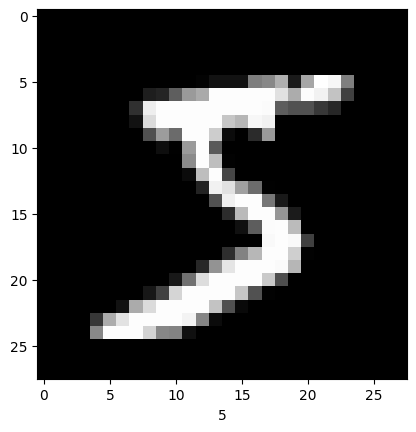

In [16]:
plt.imshow(img, cmap="gray")
plt.xlabel(label)

To prepare the data for training we have to do some preprocessing. We can specify the preprocessing we want in the `transform` argument of the dataset class. The transform is applied to each img before it is returned.

In [17]:
# You can consider the transform the "preprocessing" of the data.
# It can include augmentation.
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=0.5, std=0.5)
            ])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

img, label = train_dataset[0]
print(type(img))

# The shape now includes a dimension for the channels (our image only has one channel)
print(img.shape)

<class 'torch.Tensor'>
torch.Size([1, 28, 28])


Training is usally done in batches of images instead of one image at a time.
The `DataLoader` helps us load the images in batches so we can provide them to the network.

In [18]:
# The batch size is the number of images processed simultaneously
batch_size = 20

# The data loader yields images in batches in a random order (shuffle=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
print("number of batches", len(train_dataloader))

for batch in train_dataloader:
    imgs, labels = batch
    print(imgs.shape)
    print(labels)
    break

number of batches 3000
torch.Size([20, 1, 28, 28])
tensor([3, 4, 2, 7, 2, 9, 7, 2, 0, 9, 9, 6, 7, 8, 8, 7, 1, 9, 6, 1])


## Constructing the Network

Next, we have to construct our network by creating a class that in herites from `torch.nn.Module`. You can think of a class as a template for the creation of new objects.
For our network we have to define a constructor and the forward function.

Below is an illustration of the architecture that we will implement. It is a LeNet-5.

![LeNet](LeNet-5_architecture.svg)

By Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J. - https://github.com/d2l-ai/d2l-en, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=152265656

In [19]:
class LeNet(torch.nn.Module):
    def __init__(self):
        # This is the constructor. It is called when we create a new object from
        # our class. It creates all of the components of the neural network.
        
        # This calls the constructor of the parent class, i.e. torch.nn.Module
        super(LeNet, self).__init__()

        # Create a convolution object (filter bank) with 6 kernels of size 5x5 pixels
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # Down scale the image by binning groups of 2x2 pixels
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # Create a convolution object with 16 * 6 kernels of size 5x5 pixels
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # Down scale the image by binning groups of 2x2 pixels
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # Fully conected layers (every output is a weighted sum of all of the inputs)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

        # The activation function is the non-linear component
        # that makes neural networks more powerful that linear regression.
        self.activation_function = torch.nn.Sigmoid() 

    def forward(self, img):
        # The forward function defines how the input is processed/passed through the
        # different layers
        res = self.conv1(img)
        res = self.activation_function(res)
        res = self.pool1(res)
        res = self.conv2(res)
        res = self.activation_function(res)
        res = self.pool2(res)
        # Make the feature vector 1D
        res = torch.flatten(res, start_dim=1)
        res = self.fc1(res)
        res = self.activation_function(res)
        res = self.fc2(res)
        res = self.activation_function(res)
        res = self.fc3(res)
        return res

In [20]:
# Create an instance of the network
model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (activation_function): Sigmoid()
)


In [21]:
# Iterate over all of the parameters in the model
for name, parameters in model.named_parameters():
    # Print the name and the number of parameters
    print(name, parameters.size())
    
    # Initialize the weights for training later on
    if "weight" in name:
        torch.nn.init.xavier_normal_(parameters)

conv1.weight torch.Size([6, 1, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 5, 5])
conv2.bias torch.Size([16])
fc1.weight torch.Size([120, 400])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])


In [22]:
# Calculate the total number of trainable (`requires_grad=True`) parameters 
total_number_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nTotal number of trainable parameters:", total_number_of_parameters)


Total number of trainable parameters: 61706


## The optimizer and loss function

The optimizer defines how we update the parameters.
Every time we call optimizer.step the parameters are updated.
Classical stochastic gradient descend (SGD) updates the weights as follows:

\begin{equation}
    \theta_t = \theta_{t-1} - \gamma \frac{\partial\text{loss}}{\partial \theta}
\end{equation}

where $\theta$ is one of the parameters and $\gamma$ is the learning rate.

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

Our model outputs a vector with 10 elements for each image. These output values are often referred to as logits. To convert them into probabilities, we can normalize them so that they sum to one and are non-negative, typically by applying the softmax function. This allows us to interpret the values as probabilities. The cross-entropy loss is then used to measure how well these probabilities match the target: the correct label should have a probability close to 1, while all other labels should have probabilities close to 0.

In [25]:
loss_function = torch.nn.CrossEntropyLoss()

## The training loop

In [26]:
# Move the model to the device (CPU or GPU)
model.to(device)

# Set the model to train mode
model.train()

# A list in which we can accumulate the loss after each epoch
epoch_losses = []

# The training loop
for epoch in range(20):
    print(f"Epoch {epoch}")

    # A variable in which we accumulate the loss for all batches of an epoch
    epoch_loss = 0
    
    for data in tqdm.tqdm(train_dataloader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        
        # Reset the gradients
        optimizer.zero_grad()
        
        # Forward run through the network
        output = model(imgs)
        
        # Compute the loss
        loss = loss_function(output, labels)
        
        # Update the gradients
        loss.backward()
        
        # Update the parameters of the network
        optimizer.step()

        # Add loss of this batch to total for the epoch
        epoch_loss += loss.item()

    # Keep track of the loss for each epoch
    epoch_losses.append(epoch_loss)
    
    print("Loss:", epoch_loss)

Epoch 0


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 430.31it/s]


Loss: 6943.365732908249
Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 440.13it/s]


Loss: 6937.567579030991
Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 428.26it/s]


Loss: 3994.244040143676
Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 429.43it/s]


Loss: 339.9944055209635
Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 436.83it/s]


Loss: 213.60480017063674
Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 435.06it/s]


Loss: 162.82664322550409
Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 442.80it/s]


Loss: 130.86063544655917
Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 440.03it/s]


Loss: 114.77544898774067
Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 435.35it/s]


Loss: 97.50404137930309
Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 427.88it/s]


Loss: 82.39152281463612
Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 438.05it/s]


Loss: 73.3133898128981
Epoch 11


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 435.27it/s]


Loss: 65.251716152874
Epoch 12


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 432.61it/s]


Loss: 57.08544082373737
Epoch 13


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 432.84it/s]


Loss: 46.8093900724507
Epoch 14


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 435.80it/s]


Loss: 40.400664435570434
Epoch 15


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 430.09it/s]


Loss: 39.589235996561
Epoch 16


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 430.05it/s]


Loss: 32.44797297134028
Epoch 17


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 431.38it/s]


Loss: 28.339979193410727
Epoch 18


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 433.05it/s]


Loss: 29.081700444206035
Epoch 19


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 440.10it/s]

Loss: 23.243201300141664


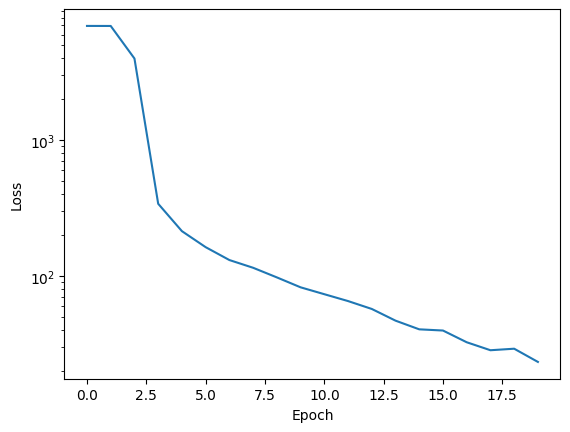

In [27]:
# Plot the loss to check for convergence
plt.plot(epoch_losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Testing a trained model

In [28]:
# To confirm that we trained our model succefully we can use a test dataset.
# Note: We don't need shuffeling here and the transform should not include any augmentations.

test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
print("\nNumber of images in the test dataset", len(test_dataset))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=6)
print("Number of batches", len(test_dataloader))


Number of images in the test dataset 10000
Number of batches 500


In [29]:
# Set the model to evaluation mode to turn off all features that are only used for training
model.eval()

# Variable to count the number of correctly classified images in the test dataset
n_correct = 0 

# Loop over all of the batches in the test data
for batch in tqdm.tqdm(test_dataloader):
    imgs = batch[0].to(device)
    labels = batch[1].to(device)

    # Forward run through the network
    output = model(imgs)

    # Convert the output into discrete predictions
    predicted_labels = output.max(dim=1).indices
    
    # Count the correctly classified images
    correct_labels = labels == predicted_labels
    n_correct += torch.sum(correct_labels).item()
    
print(f"Correctly classified numbers in test dataset: {n_correct / len(test_dataset) * 100}%")

100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 634.27it/s]

Correctly classified numbers in test dataset: 98.89%


## Saving a trained model

The easiest way to save the result of your training is by saving the so called state dictionary. This contains the model parameters. However, it is important to realize that we need the model class in addition to the saved state dict to load the model.

In [30]:
# Saving model weights
torch.save(model.state_dict(), "./model_weights.pth")

# Loading model weights
new_model = LeNet()
new_model.load_state_dict(torch.load("./model_weights.pth"))

<All keys matched successfully>

Alternatively, you could use the onnx format which save all the relevant information to load the model. In fact it even allows you to execute the model in a different programming language, such as C++.

## Visualizing the convolutional kernels (optional)

Looking at the kernels of the first convolutional layer, shows us how difficult it is to interpret what the neural network has learned. The kernels seem arbitrary.

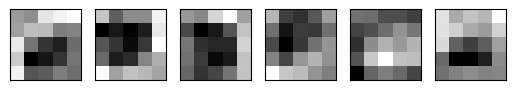

In [31]:
kernels = model.conv1.weight.detach().cpu()
fig, axes = plt.subplots(1, len(kernels))
for i in range(len(kernels)):
    axes[i].imshow(kernels[i, 0], cmap="gray")
    axes[i].set_xticks([], [])
    axes[i].set_yticks([], [])
plt.show()

# Transfer learning example

For this example we will use one of `torchvision`'s pretrained models.
The ResNet18 is one a relatively small deep neural network usally used for image classification.
We will initialize our network with the weights trained on ImageNet (a dataset of images that are classified in 1000 categories). We will adapt this network to a smaller dataset with only 10 categories.

In [32]:
# Load the model with the ImageNet weights
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
total_number_of_parameters = sum(p.numel() for p in model.parameters())
print("\nTotal number of parameters:", total_number_of_parameters)


Total number of parameters: 11689512


Since our dataset is much smaller, we would like to reduce number of parameters to speed up training and prevent overfitting.
To exclude them for the optimization process we can turn off `requires_grad`, this is often refered to as 'freezing'.

In [34]:
# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

# Check the number of trainable parameters
total_number_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nTotal number of trainable parameters:", total_number_of_parameters)


Total number of trainable parameters: 0


Since our dataset has 10 instead of 1000 classes we have to slightly change the architecture of the model.
We replace the fully connected layer at the end with a fully connected layer with only 10 output features.

In [35]:
# Replace the classifier (fully connected layer) for our task (10 instead of 1000 classes)
model.fc = torch.nn.Linear(512, 10)
torch.nn.init.xavier_normal_(model.fc.weight)

# Check that the new layer is trainable
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name, param.size())

total_number_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nTotal number of trainable parameters:", total_number_of_parameters)

fc.weight torch.Size([10, 512])
fc.bias torch.Size([10])

Total number of trainable parameters: 5130


We load the data the same way we did for the example above.
It is important that we use the same transform (preprocessing) as original dataset (ImageNet).

In [36]:
transform = torchvision.models.ResNet18_Weights.DEFAULT.transforms()
# transform = torchvision.transforms.ToTensor()

batch_size = 200

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
print("\nNumber of images in the train dataset", len(train_dataset))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)
print("Number of batches", len(train_dataloader))

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
print("\nNumber of images in the test dataset", len(test_dataset))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)
print("Number of batches", len(test_dataloader))

# The names of the 10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Number of images in the train dataset 50000
Number of batches 250

Number of images in the test dataset 10000
Number of batches 50


Let's take a look a the images.
The colours look weird because of the normalizations implied in transform.
We can fix that by setting `transform = torchvision.transforms.ToTensor()` in the cell above.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..1.1529241].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.1345534].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.0299783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2102921..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6932774].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.06

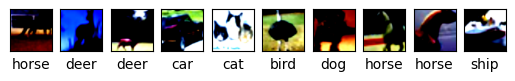

In [37]:
for data in train_dataloader:
    imgs = data[0]
    labels = data[1]
    n_images = min(10, len(imgs))
    fig, axes = plt.subplots(1, n_images)
    for i, img in enumerate(torch.squeeze(imgs)[:n_images]):
        axes[i].imshow(img.moveaxis(0,2))
        axes[i].set_xticks([], [])
        axes[i].set_yticks([], [])
        axes[i].set_xlabel(classes[labels[i].item()])
    plt.show()
    break

The training loop is the same as for the previous example.

In [38]:
# Optimize only the classifier
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# Move the model to the device (CPU or GPU)
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
running_losses = []

# The training loop
for epoch in range(5):
    print(f"Epoch {epoch}")
    running_loss = 0
    for data in tqdm.tqdm(train_dataloader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        # Reset the gradients
        optimizer.zero_grad()
        # Forward run throught the network
        output = model(imgs)
        # Compute the loss
        loss = loss_function(output, labels)
        # Update the gradients
        loss.backward()
        # Update the parameters of the network
        optimizer.step()

        running_loss += loss.item()
    running_losses.append(running_loss)
    print("Loss", running_loss)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.64it/s]


Loss 231.02064609527588
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████| 250/250 [01:09<00:00,  3.60it/s]


Loss 170.91717714071274
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████| 250/250 [01:09<00:00,  3.58it/s]


Loss 163.45672580599785
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████| 250/250 [01:10<00:00,  3.56it/s]


Loss 157.85209023952484
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████| 250/250 [01:10<00:00,  3.54it/s]

Loss 156.06553304195404


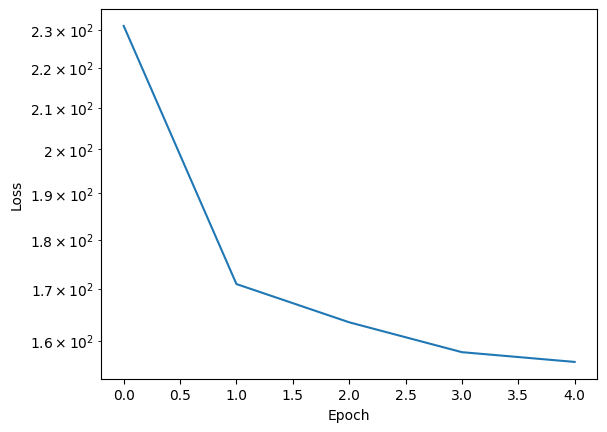

In [39]:
plt.plot(running_losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

To evaluate performance we can calculate how many of the test images are classified correctly.

In [41]:
model.eval()
device = torch.device("cuda:0")
model.to(device)
n_correct = 0 
for data in tqdm.tqdm(test_dataloader):
    imgs = data[0].to(device)
    labels = data[1].to(device)
    output = model(imgs)
    correct_labels = labels == output.max(dim=1).indices
    n_correct += torch.sum(correct_labels).item()
    
print(f"Correctly classified images in test dataset: {n_correct / len(test_dataset) * 100}%")

100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.51it/s]

Correctly classified images in test dataset: 78.01%


# Feedback

https://forms.gle/6YKMgShX4h9QsWmR9

![QR](QR_code_feedback.png)